### LLM Analize Petro Comments

In [18]:
import os
from pydantic import BaseModel, Field
import json
from datetime import datetime
import time


import pandas as pd
from dotenv import load_dotenv
from openai import OpenAI
import emoji
import matplotlib.pyplot as plt
import numpy as np
import ast
import logging
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from scipy.stats import norm

In [86]:
class CommentResponseFormat(BaseModel):
    """
    The response format for the comment analisys.
    """
    score: str = Field(
        description="Score from 1 to 5, where 1 is terrible and 5 is excellent."
    )

In [87]:
load_dotenv("./.env")
GROK_API_KEY = os.getenv("GROK_API_KEY")

In [88]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [89]:
client = OpenAI(
    api_key=GROK_API_KEY,
    base_url="https://api.x.ai/v1",
)

def comments_analisys_llm_api(row) -> dict:
    """
    Call the Grok API to get the sentiment and topic of the video transcription.

    Args:
        row (dict): A dictionary containing the video data like:
            video_id (str): The ID of the video.
            video_timestamp (str): The timestamp of the video.
            hashtag (str): The hashtag associated with the video.
            author_username (str): The username of the author of the video.
            video_description (str): The description of the video.
            video_transcription (str): The transcription of the video.
    Returns:
        dict: The sentiment and topic of the transcription.
    """
    try:
        # parsed_date = datetime.strptime(row['date'], "%Y-%m-%dT%H:%M:%S")
        parsed_date = datetime.strptime(row['date'], "%d-%m-%Y %H:%M")
        time.sleep(0.2)  # Avoid rate limit issues
        grok_request = client.beta.chat.completions.parse(
            model="grok-3-mini-fast-beta",
            messages=[
                {
                    "role": "system",
                    "content": f"I'm analyzing videos related to Gustavo Petro, and the video is about {row["topic"]} ,based in the comment in relation to the video and/or Gustavo Petro, give me the sentiment in a scale of 1-5, if you really think the comment makes no sense or is not related with the topics and it is difficult to set a score give me NA but be careful if the comment supports opposing ideas or people, try to return a score.",
                },
                {
                    "role": "user", 
                    "content": f"comment:{row["text"]}"
                }
            ],
            response_format=CommentResponseFormat,
            reasoning_effort="low",
            temperature=0.5,
        )
    except Exception as e:
        print(f"Error trying to call Grok API: {e}")
        return {'date': parsed_date, 'video_id': row['video_id'], 'hashtag': row['hashtag'], "topic":row["topic"],'text': row["text"], 'llm_reasoning': str(e)} | {"score": "NA"}

    result = json.loads(grok_request.choices[0].message.content)
    reasoning = grok_request.choices[0].message.reasoning_content
    return {'date': parsed_date, 'video_id': row['video_id'], 'hashtag': row['hashtag'], "topic":row["topic"], 'text': row["text"], 'llm_reasoning': reasoning} | result

In [37]:
def is_emoji_only(text:str) -> bool:
    """
    Check if a string contains only emojis (no letters, numbers, or other meaningful characters).
    args:
        text (str): The string to check.
    Returns:
        bool: True if the string contains only emojis, False otherwise.
    """
    if not isinstance(text, str):
        return False
    # Remove emojis and check if any non-whitespace characters remain
    text_no_emojis = emoji.replace_emoji(text, replace='')
    return len(text_no_emojis.strip()) == 0 and len(text) > 0

In [31]:
def load_video_results(file_path: str) -> pd.DataFrame:
    """
    Load video results from a CSV file and preprocess the data.
    Args:
        file_path (str): The path to the CSV file.
    Returns:
        pd.DataFrame: A DataFrame containing the preprocessed video results.
    """
    df = pd.read_excel(file_path,sheet_name='results', dtype=str)
    df['date'] = pd.to_datetime(df['date'])
    df['score'] = df['score'].astype(int)

    # Filter out rows where 'topic' contains 'NA'
    mask = (
        (df["topic"].str.contains("NA", na=False)) | (df["topic"].str.contains("NT", na=False))
    )
    df = df[~mask]

    # Filter out rows greater than 2022-08
    df = df[df['date'] > '2022-08-01']
    df["topic"] = df['topic'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

    return df

In [32]:
def merge_video_comments_df(videos_df: pd.DataFrame, comments_df: pd.DataFrame) -> pd.DataFrame:
    """
    Merge videos comments DataFrame with the main videos DataFrame.
    Args:
        videos_df (pd.DataFrame): The main DataFrame containing videos data.
        comments_df (pd.DataFrame): The DataFrame containing comments data.
    Returns:
        pd.DataFrame: The merged DataFrame.
    """
    # Merge df_comments with df_videos to keep only matching video_id and add topic, hashtag
    df_comments_enriched = comments_df.merge(
        videos_df[['video_id', 'topic', 'hashtag']],
        on='video_id',
        how='left'
    )
    # Remove rows where 'topic' is NaN or empty
    df_comments_enriched = df_comments_enriched.dropna(subset=['topic'], how='all')
    return df_comments_enriched

In [33]:
def stratified_sample(df:pd.DataFrame, strata_column:str, sample_size) -> pd.DataFrame:
    """
    Perform stratified sampling on a dataframe
    
    Parameters:
    dataframe: pandas dataframe
    strata_column: column to stratify on
    sample_size: amount of items to sample or dictionary with strata as keys
    
    Returns:
    Sampled dataframe
    """
    samples = []
    
    # Get unique strata
    strata = df[strata_column].unique()
    
    for stratum in strata:
        stratum_df = df[df[strata_column] == stratum]
        
        # Determine sample size for this stratum
        if isinstance(sample_size, dict):
            if stratum in sample_size:
                size_or_frac = sample_size[stratum]
            else:
                size_or_frac = 1000  # default
        else:
            size_or_frac = sample_size
            
        sample_target = min(size_or_frac, len(stratum_df))
        stratum_sample = stratum_df.sample(n=sample_target, random_state=42)
        samples.append(stratum_sample)
    
    # Combine samples from all strata
    return pd.concat(samples)

#### Process comments data with LLM

In [34]:
df_video_results = load_video_results(r"results\video_sentiment_analysis_llm_petro_v3.xlsx")

In [35]:
# Load the Excel file into a DataFrame
df_comments = pd.read_excel(r"D:\Documentos\camilo\Maestria\TESIS\TikTokAnalyticsProject\output\video_info_04-02-2025_1209_Petro_V2.xlsx",sheet_name='comments_data', dtype=str)
df_comments['date'] = pd.to_datetime(df_comments['date'])

C:\Users\ecmar\AppData\Local\Temp\ipykernel_976\3931606846.py:3: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_comments['date'] = pd.to_datetime(df_comments['date'])


In [ ]:
# Filter out rows where text comment is NaN
df_comments = df_comments.dropna(subset=['text'], how='all')

# Filter out rows where text comment is emoji-only or empty
mask = (
    (df_comments['text'].apply(is_emoji_only) ) | (df_comments['text'].isna() | df_comments['text'].eq(''))
)
df_comments = df_comments[~mask]

In [97]:
df_comments_enriched = merge_video_comments_df(df_video_results, df_comments)
# Delete comments with the hashtag "GobiernoColombiano"
df_comments_enriched = df_comments_enriched[df_comments_enriched["hashtag"] != "GobiernoColombiano"]

In [98]:
len(df_comments_enriched)

110780

In [99]:
df_comments_enriched['month'] = df_comments_enriched['date'].dt.to_period('M')

In [ ]:
df_comments_enriched.groupby('month').size().sort_index(ascending=True).plot(kind='bar', figsize=(15, 6), color='skyblue', grid=True, title='Original Number of Comments per Month')

Sample to reduce costs and speed up the process

In [101]:
# sample_sizes = {2022: 0, 2023: 0, 2024: 0.2, 2025: 0.1}
# Sample mas 2000 comments
df_comments_sampled = stratified_sample(df_comments_enriched, 'month', 2000)
# threshold date for > 2024-01 to reduce cost
df_comments_sampled = df_comments_sampled[df_comments_sampled["month"] >=  pd.Period('2024-01', freq='M')]
df_comments_sampled["date"] = df_comments_sampled["date"].dt.strftime("%d-%m-%Y %H:%M")
print("Sampled comments: ",len(df_comments_sampled))

Sampled comments:  28226


In [102]:
# df_test = df_comments_sampled.sample(n=10, random_state=72)
# display(df_test)

In [ ]:
# Process the comments using the LLM API
df_sentiment = df_comments_sampled.apply(comments_analisys_llm_api, axis=1)
df_sentiment = pd.json_normalize(df_sentiment)

In [ ]:
# Save the DataFrame to an Excel file
# df_sentiment.to_excel(r"results\comment_sentiment_analysis_llm_petro_v3.xlsx", index=False, sheet_name="results", header=True)

#### Results analysis with Python

In [6]:
def count_ratings_by_month(df:pd.DataFrame, min_video_amount:int=0, month_window:int=2, alpha:int=0.1) -> pd.DataFrame:
    """
    Count the number of ratings by month and score, and calculate the average rating and percentages.
    Args:
        df (pd.DataFrame): DataFrame containing the video data with 'date', 'score' and 'total' columns.
        min_video_amount (int): Minimum number of videos to decide if apply Moving average smoothing.
        month_window (int): Number of months to consider for the rolling average.
    Returns:
        pd.DataFrame: DataFrame with the average rating and it's percentages.
    """
    
    # Make sure the date column is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a month column
    df['month'] = df['date'].dt.to_period('M')
    
    # Group by month and rate, then count
    result = df.groupby(['month', 'score']).size().unstack(fill_value=0)
    
    # Add a total column
    result['total'] = result.sum(axis=1)

    #Calculate Average
    temp_df = df[['month', 'score']].copy()

    # Group by month and calculate mean
    avg_ratings = temp_df.groupby('month')['score'].mean().round(2)

    result['average_rating'] = avg_ratings

    # Calculate percentages for each rating by month
    for rating in range(1, 6):
        result[f"{rating}_percent"] = (result[rating] / result['total'] * 100).round(2)

    # Apply moving average smoothing for the percentages if the total number of videos is greater than the minimum amount
    if min_video_amount > 0:
        for rating in range(1, 6):
            # Apply Exponential Moving Average (EMA)
            result[f"{rating}_percent"] = np.where(result['total'] <= min_video_amount, result[f"{rating}_percent"].ewm(alpha=alpha).mean().round(2), result[f"{rating}_percent"])
            # Apply moving average smoothing
            # result[f"{rating}_percent"] = np.where(result['total'] <= min_video_amount, result[f"{rating}_percent"].rolling(window=month_window, min_periods=1).mean().round(2), result[f"{rating}_percent"])

    # Apply moving average smoothing for the average rating if the total number of videos is greater than the minimum amount
    if min_video_amount > 0:
        # Apply Exponential Moving Average (EMA)
        result['average_rating'] = np.where(result['total'] <= min_video_amount, result['average_rating'].ewm(alpha=alpha).mean().round(2), result['average_rating'])
        # Apply moving average smoothing
        # result['average_rating'] = np.where(result['total'] <= min_video_amount, result['average_rating'].rolling(window=month_window, center=True, min_periods=1).mean().round(2), result['average_rating'])
    
    return result

In [7]:
def visualize_rating_percentages(df) -> None:
    """
    Create visualizations for rating percentages by month and average rating over time.
    
    Parameters:
    df: DataFrame with index=score_month and columns 1, 2, 3, 4, 5, total, average_rating
    
    Returns:
    None (displays plots)
    """
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Get months from index
    months = df_copy.index
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # 1. Stacked bar chart - Rating distribution by month
    x = np.arange(len(months))
    width = 0.8
    
    # Get percentage data for each rating
    rating_percentages = [df_copy[f"{rating}_percent"].values for rating in range(1, 6)]
    
    # Colors for ratings
    colors = ['#FF9999', '#FFD699', '#9999FF','#b0e69c','#11ff9a']
    
    # Create the stacked bar chart
    bottom = np.zeros(len(months))
    for i, data in enumerate(rating_percentages):
        label = f"{i+1} Star"
        ax1.bar(x, data, width, bottom=bottom, label=label, color=colors[i])
        bottom += data
    
    ax1.set_title('Rating Distribution by Month', fontsize=14)
    ax1.set_ylabel('Percentage (%)')
    ax1.set_xticks(x)
    ax1.set_xticklabels(months, rotation=45, ha='right')
    ax1.set_xlabel('')
    ax1.legend(title='Rating')
    
    # 2. Line chart for average rating over time
    ax2.plot(x, df_copy['average_rating'], marker='o', linewidth=2, color='#3366CC')
    
    # Add data labels
    for i, val in enumerate(df_copy['average_rating']):
        ax2.text(i, val + 0.05, f"{val}", ha='center', va='bottom', fontsize=10)
    
    ax2.set_title('Average Rating by Month', fontsize=14)
    ax2.set_ylabel('Average Rating')
    ax2.set_xticks(x)
    ax2.set_xticklabels(months, rotation=45, ha='right')
    ax2.set_ylim(min(df_copy['average_rating'])-0.5, max(df_copy['average_rating'])+0.5)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Add horizontal line at rating 4.0 for reference
    ax2.axhline(y=4.0, color='r', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional visualization - Heatmap of percentage distribution using imshow
    fig, ax = plt.subplots(figsize=(25, 6))
    
    # Prepare heatmap data
    # heatmap_data = np.array([df_copy[f"{i}_percent"].values for i in range(1, 6)])
    heatmap_data = np.array([df_copy[f"{i}_percent"].values for i in range(5, 0, -1)])
    
    # Create heatmap using imshow
    im = ax.imshow(heatmap_data, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    
    # Add colorbar
    cbar = plt.colorbar(im)
    cbar.set_label('Percentage (%)')
    
    # Set ticks and labels
    ax.set_xticks(np.arange(len(months)))
    ax.set_xticklabels(months, rotation=45, ha='right')
    ax.set_yticks(np.arange(5))
    ax.set_yticklabels([f"{i}★" for i in range(5, 0, -1)])
    
    # Add text annotations to heatmap
    for i in range(5):
        for j in range(len(months)):
            text = ax.text(j, i, f"{heatmap_data[i, j]:.1f}%",
                          ha="center", va="center", color="black")
    
    plt.title('Percentage of Rating by Month', fontsize=14)
    plt.tight_layout()
    plt.show()

In [8]:
def visualize_rating_percentages2(df) -> None:
    """
    Create separate visualizations:
    - Rating distribution by month (stacked bar chart)
    - Average rating over time with 95% confidence interval
    
    Parameters:
    df: DataFrame with index=score_month and columns 1, 2, 3, 4, 5, total, average_rating
    
    Returns:
    None (displays plots)
    """
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()

    # Get months from index
    months = df_copy.index
    x = np.arange(len(months))

    # ----------- First Plot: Stacked Bar Chart -----------
    plt.figure(figsize=(15, 6))

    # Get percentage data for each rating
    rating_percentages = [df_copy[f"{rating}_percent"].values for rating in range(1, 6)]
    colors = ['#FF9999', '#FFD699', '#9999FF', '#b0e69c', '#11ff9a']
    bottom = np.zeros(len(months))

    for i, data in enumerate(rating_percentages):
        label = f"{i+1} Star"
        plt.bar(x, data, width=0.8, bottom=bottom, label=label, color=colors[i])
        bottom += data

    plt.title('Rating Distribution by Month', fontsize=14)
    plt.ylabel('Percentage (%)')
    plt.xticks(x, months, rotation=45, ha='right')
    plt.xlabel('')
    plt.legend(title='Rating')
    plt.tight_layout()
    plt.show()

    # ----------- Second Plot: Line Chart with Confidence Interval -----------

    # Estimate standard deviation using assumed binomial variance
    # p = average_rating / 5; std = sqrt(p * (1 - p) / n) * 5
    p = df_copy['average_rating'] / 5
    n = df_copy['total']  # Make sure 'total' column = number of ratings per month
    se = np.sqrt(p * (1 - p) / n) * 5
    ci_95 = 1.96 * se

    plt.figure(figsize=(15, 6))
    plt.plot(x, df_copy['average_rating'], marker='o', linewidth=2, color='#3366CC', label='Average Rating')

    # Shaded area for confidence interval
    plt.fill_between(x,
                     df_copy['average_rating'] - ci_95,
                     df_copy['average_rating'] + ci_95,
                     color='#3366CC',
                     alpha=0.2,
                     label='95% Confidence Interval')

    # Add data labels
    for i, val in enumerate(df_copy['average_rating']):
        plt.text(i, val + 0.05, f"{val:.2f}", ha='center', va='bottom', fontsize=10)

    plt.title('Average Rating by Month', fontsize=14)
    plt.ylabel('Average Rating')
    plt.xticks(x, months, rotation=45, ha='right')
    plt.ylim(min(df_copy['average_rating']) - 0.5, max(df_copy['average_rating']) + 0.5)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.axhline(y=4.0, color='r', linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [9]:
df_sentiment = pd.read_excel(r"results\comment_sentiment_analysis_llm_petro_v3.xlsx",sheet_name='results', dtype=str)

In [10]:
# Filter out rows where 'score' contains 'NA'
mask = (
    df_sentiment["score"].str.contains("NA", na=False)
)
df_sentiment = df_sentiment[~mask]
df_sentiment = df_sentiment.dropna(subset=['score'], how='all')

In [11]:
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment['score'] = df_sentiment['score'].astype(int)

In [12]:
df_sentiment["topic"] = df_sentiment['topic'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [13]:
len(df_sentiment)

25017

score
5    11566
4     3595
3      800
2     2138
1     6918
Name: count, dtype: int64


<Axes: title={'center': 'Comments score distribution'}>

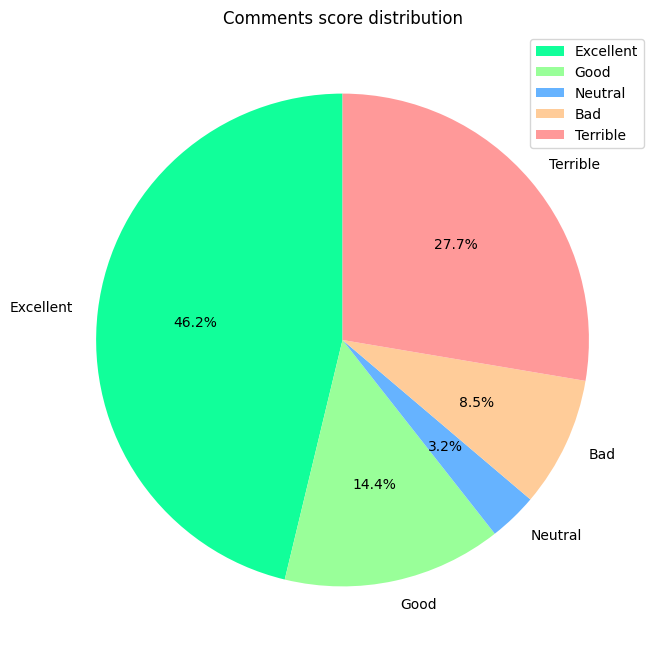

In [9]:
counts = df_sentiment["score"].value_counts()
counts = counts.sort_index(ascending=False)
print(counts)

percentage = (counts/len(df_sentiment))*100
resumen = pd.DataFrame({'counts': counts,     'percentage': percentage })
resumen['percentage'].plot.pie(autopct='%1.1f%%', figsize=(8, 8), labels=["Excellent","Good","Neutral","Bad","Terrible"], title='Comments score distribution', ylabel='', legend=True, fontsize=10, startangle=90, colors=['#11ff9a','#99ff99','#66b3ff','#ffcc99','#ff9999'])

In [14]:
monthly_counts_df = count_ratings_by_month(df_sentiment.sort_values(by='date'), min_video_amount=0, month_window=3, alpha=0.2)

<Axes: title={'center': 'Total Comments by Month'}, xlabel='Month', ylabel='Amount of comments'>

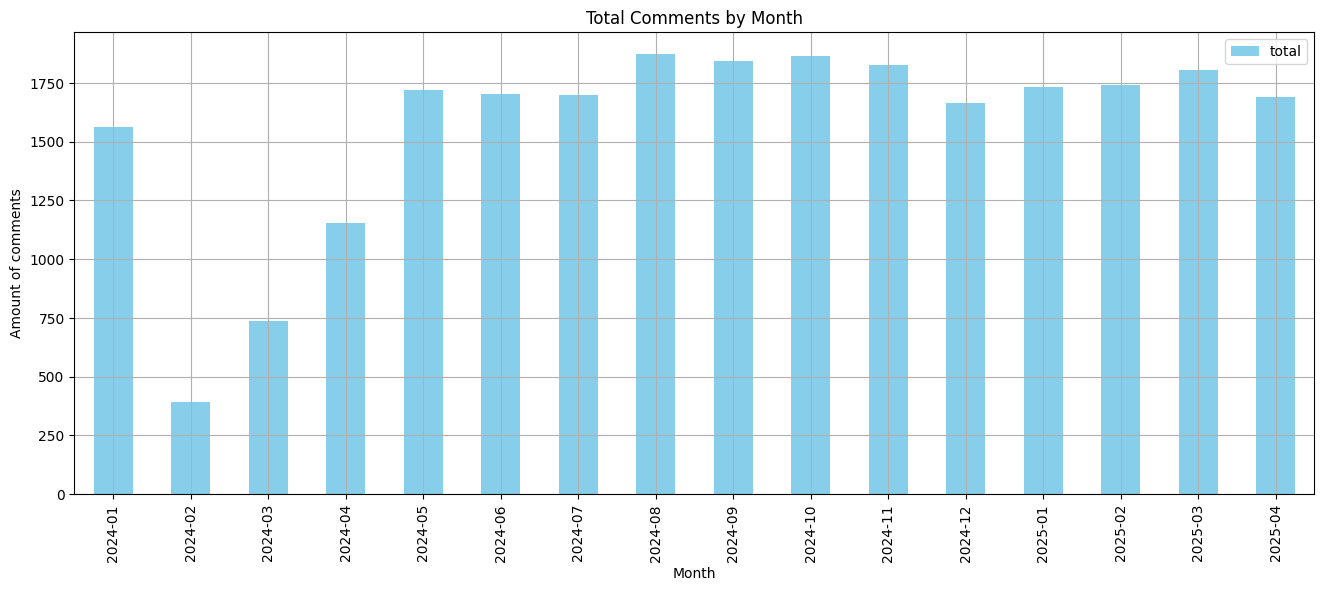

In [11]:
monthly_counts_df.plot.bar(y='total', figsize=(16, 6), title='Total Comments by Month', xlabel='Month', ylabel='Amount of comments', grid=True, color='skyblue')

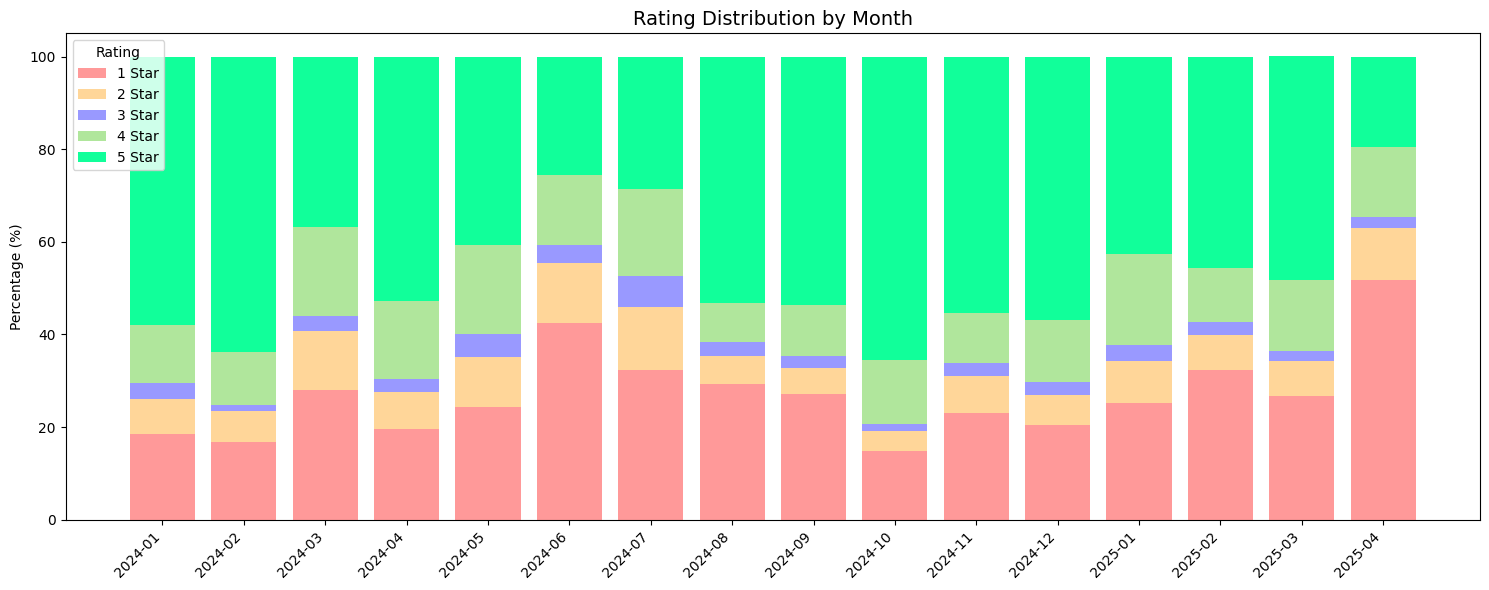

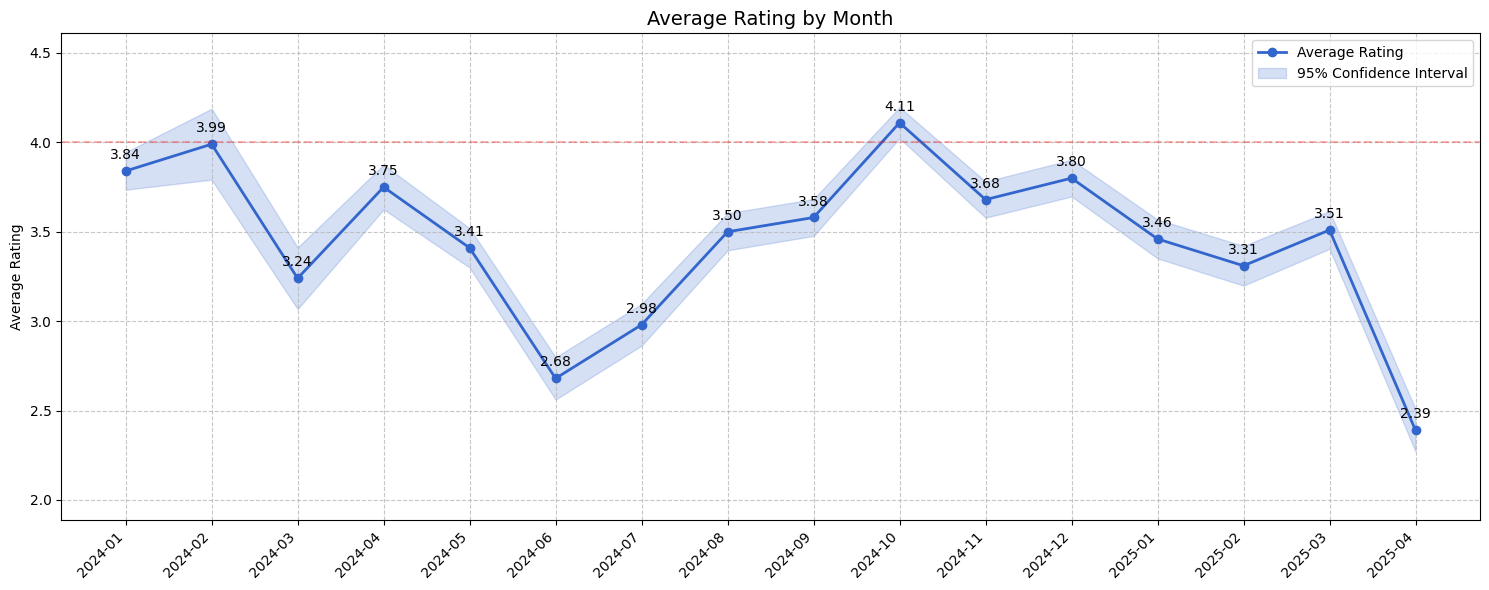

In [15]:
visualize_rating_percentages2(monthly_counts_df)

In [16]:
def create_topic_visualizations(df_in):
    """
    Create visualizations for topic percentages (total and per month)
    
    Parameters:
    df_in: DataFrame with columns topic (lists of topics), video_id, date
    
    Returns:
    None (displays plots)
    """
    # Create a copy to avoid modifying the input
    df = df_in.copy()
    
    # Ensure topic column contains lists; handle non-list or NaN values
    df['topic'] = df['topic'].apply(lambda x: x if isinstance(x, list) else [] if pd.isna(x) else [x])
    
    # Explode the topic column to have one topic per row
    df = df.explode('topic').reset_index(drop=True)
    
    # Remove rows with empty or invalid topics
    df = df[df['topic'].notna() & (df['topic'] != '')]
    
    # Add month column for grouping
    df['month'] = df['date'].dt.strftime('%Y-%m')
    
    # Figure 1: Total Percentage of Topics (Bar Chart)
    plt.figure(figsize=(15, 6))
    
    # Count total occurrences of each topic
    topic_counts = df['topic'].value_counts()
    total_topics = topic_counts.sum()
    topic_percentages = (topic_counts / total_topics * 100).round(1)
    
    # Sort from highest to lowest
    topic_percentages = topic_percentages.sort_values(ascending=False)
    
    # Get colors - one for each topic
    # colors = plt.cm.tab20(np.linspace(0, 1, len(topic_percentages)))

    # Define color scheme for 28 topics (combine tab20 and tab20c)
    # colors = np.vstack([plt.cm.tab20(np.linspace(0, 1, 20)), plt.cm.tab20b(np.linspace(0, 1, 20))])[:28]
    colors = np.vstack([plt.cm.tab20(np.linspace(0, 1, 20))])
    
    # Create bar chart
    ax = plt.bar(topic_percentages.index, topic_percentages, color=colors, edgecolor='white', linewidth=1)
    
    # Add percentage labels on top of bars (for bars with >= 5%)
    for bar in ax:
        height = bar.get_height()
        if height >= 5:
            plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', 
                     ha='center', va='bottom', fontsize=10)
    
    # Customize plot
    plt.title('Total Percentage of Topics', fontsize=16)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Figure 2: Percentage of Topics by Month
    # Get topic counts per month
    monthly_topics = df.groupby(['month', 'topic']).size().unstack(fill_value=0)
    
    # Calculate percentages for each month
    monthly_percentages = monthly_topics.div(monthly_topics.sum(axis=1), axis=0) * 100
    
    # Sort months chronologically
    monthly_percentages = monthly_percentages.sort_index()
    
    # Get unique topics and sort by overall frequency
    all_topics = topic_counts.index.tolist()
    
    # Ensure all topics are in the monthly data (fill missing with zeros)
    for topic in all_topics:
        if topic not in monthly_percentages.columns:
            monthly_percentages[topic] = 0
    
    # Reorder columns by overall frequency
    monthly_percentages = monthly_percentages[all_topics]
    
    # Plot stacked bar chart
    plt.figure(figsize=(15, 10))
    
    # Plot stacked bars
    ax = monthly_percentages.plot(kind='bar', stacked=True, figsize=(18, 8), 
                                 color=colors, width=0.8)
    
    # Add labels and title
    plt.title('Percentage of Topics by Month', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add percentage labels on bars
    for container in ax.containers:
        ax.bar_label(container, labels=['%.1f%%' % x if x >= 5 else '' for x in container.datavalues], 
                    label_type='center')
    
    plt.tight_layout()
    plt.show()
    
    # Figure 3: Topic Trends Over Time (Line Chart)
    plt.figure(figsize=(15, 6))
    
    # Get top 4 topics for clarity
    top_topics = topic_counts.nlargest(3).index.tolist()
    
    # Plot line for each top topic
    for topic in top_topics:
        if topic in monthly_percentages.columns:
            plt.plot(monthly_percentages.index, monthly_percentages[topic], 
                    marker='o', linewidth=2, label=topic)
    
    plt.title('Trend of Top 3 Topics Over Time', fontsize=16)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Topic')
    
    plt.tight_layout()
    plt.show()

In [15]:
def group_df_by_topic(df:pd.DataFrame) -> pd.DataFrame:
    """
    Group DataFrame by topic and calculate average score for each topic.
    
    Parameters:
    df: DataFrame with columns 'topic' (lists of topics), 'score'
    
    Returns:
    DataFrame with average score for each topic
    """
    grouped_topic_list = [
        {
            "topic": "Politics",
            "group": ["politics","reforms","labor reform","human rights","sports"]
        },
        {
            "topic": "Infrastructure",
            "group": ["infrastructure","transportation"]
        },
        {
            "topic": "Armed conflict",
            "group": ["armed conflict"]
        },
        {
            "topic": "Public Appearance",
            "group": ["public appearance","personal life"]
        },
        {
            "topic": "Social Development",
            "group": ["rural development","regional development","justice social"]
        },
        {
            "topic": "Governance",
            "group": ["governance"]
        },
        {
            "topic": "Corruption",
            "group": ["corruption"]
        },
        {
            "topic": "Economy",
            "group": ["economy"]
        },
        {
            "topic": "Elections",
            "group": ["elections"]
        },
        {
            "topic": "Foreign Relations",
            "group": ["foreign relations"]
        },
        {
            "topic": "Security",
            "group": ["security"]
        },
        {
            "topic": "Peace Process",
            "group": ["peace process"]
        },
        {
            "topic": "Healthcare",
            "group": ["healthcare"]
        },
        {
            "topic": "Employment",
            "group": ["employment"]
        },
        {
            "topic": "Education",
            "group": ["education"]
        },
        {
            "topic": "Environment",
            "group": ["environment"]
        },
        {
            "topic": "Narcotraffic",
            "group": ["narcotraffic"]
        },
        {
            "topic": "Migration",
            "group": ["migration"]
        }
    ]
    
    # Explode the topic column to have one topic per row
    df_sentiment_grouped = df.explode('topic').reset_index(drop=True)
    for group in grouped_topic_list:
        df_sentiment_grouped["topic"] = np.where(
            df_sentiment_grouped["topic"].str.lower().isin(group["group"]),
            group["topic"],
            df_sentiment_grouped["topic"]
        )
    
    return df_sentiment_grouped

In [16]:
df_sentiment_grouped = group_df_by_topic(df_sentiment)

In [19]:
def create_topic_vs_score_visualizations(df: pd.DataFrame) -> None:
    """
    Create improved visualizations for topic vs score.
    
    Parameters:
    df: DataFrame with columns 'topic' (string), 'score', and 'video_id'
    
    Returns:
    None (displays plots)
    """
    # Create a copy to avoid modifying input
    df_copy = df.copy()
    
    # Group by topic to compute statistics
    topic_summary = df_copy.groupby('topic').agg(
        average_score=('score', 'mean'),
        std_score=('score', 'std'),
        total_videos=('video_id', 'nunique')
    ).reset_index()
    
    # Calculate standard error
    # topic_summary['standard_error'] = topic_summary['std_score'] / np.sqrt(topic_summary['total_videos'])
    
    # Sort by average_score (descending)
    topic_summary = topic_summary.sort_values('average_score', ascending=False)
    
    # Define colors (tab20b + tab20c for 28 topics)
    colors = plt.cm.tab20(np.linspace(0, 1, 18))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(20, 6))
    
    # Plot bars for average_score
    bars = ax1.bar(
        topic_summary['topic'],
        topic_summary['average_score'],
        # yerr=topic_summary['standard_error'],  # Error bars
        # capsize=3,  # Error bar caps
        color=colors,
        linewidth=1.5,
        alpha=0.8,
        width=0.4  # Narrower bars
    )
    
    # Annotate bars with average_score
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.05,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=12
        )
    
    # Customize ax1 (average_score)
    ax1.set_title('Average Comment Score by Topic', fontsize=16, pad=5)
    ax1.set_ylabel('Average Score (1-5)', fontsize=12)
    ax1.tick_params(axis='y')
    ax1.set_xticks(range(len(topic_summary['topic'])))
    ax1.set_xticklabels(topic_summary['topic'], rotation=45, ha='right', fontsize=13)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax1.set_ylim(0, 5)  # Adjust for annotations
    
    # Tight layout
    plt.tight_layout()
    plt.show()

In [23]:
def create_topic_vs_score_visualizations(df: pd.DataFrame) -> None:
    """
    Create improved visualizations for topic vs score.
    
    Parameters:
    df: DataFrame with columns 'topic' (string), 'score', and 'video_id'
    
    Returns:
    None (displays plots)
    """
    # Create a copy to avoid modifying input
    df_copy = df.copy()

    # Group by topic to compute statistics
    topic_summary = df_copy.groupby('topic').agg(
        average_score=('score', 'mean'),
        std_score=('score', 'std'),
        total_videos=('video_id', 'nunique')
    ).reset_index()

    # Calculate standard error and 95% CI
    topic_summary['standard_error'] = topic_summary['std_score'] / np.sqrt(topic_summary['total_videos'])
    topic_summary['ci_95'] = 1.96 * topic_summary['standard_error']

    # Sort by average_score (descending)
    topic_summary = topic_summary.sort_values('average_score', ascending=False)

    # Define colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(topic_summary)))

    # Create figure
    fig, ax1 = plt.subplots(figsize=(20, 6))

    # Plot bars with CI error bars
    bars = ax1.bar(
        topic_summary['topic'],
        topic_summary['average_score'],
        yerr=topic_summary['ci_95'],  # 95% Confidence Intervals
        capsize=5,
        color=colors,
        linewidth=1.5,
        alpha=0.8,
        width=0.4,
        edgecolor='black',
        ecolor='#424242'
    )

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2 - 0.1,
            height + 0.05,
            f'{height:.2f}',
            ha='right',
            va='bottom',
            fontsize=12
        )

    # Customize plot
    ax1.set_title('Average Comments Score by Topic', fontsize=16, pad=5)
    ax1.set_ylabel('Average Score (1-5)', fontsize=12)
    ax1.tick_params(axis='y')
    ax1.set_xticks(range(len(topic_summary['topic'])))
    ax1.set_xticklabels(topic_summary['topic'], rotation=45, ha='right', fontsize=13)
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)
    ax1.set_ylim(0, 5)

    # Add legend for CI
    plt.legend(handles=[mpatches.Patch(color='#424242', label='95% Confidence Intervals')], loc='upper right', fontsize=10, frameon=False)
    # Final layout
    plt.tight_layout()
    plt.show()

In [21]:
def create_topic_visualizations_2(df_in):
    """
    Create visualizations for topic percentages with confidence intervals.
    
    Parameters:
    df_in: DataFrame with columns topic (lists of topics), video_id, date
    
    Returns:
    None (displays plots)
    """
    df = df_in.copy()

    df['month'] = df['date'].dt.strftime('%Y-%m')

    # Topic counts and percentages
    topic_counts = df['topic'].value_counts()
    total = topic_counts.sum()
    topic_percentages = (topic_counts / total * 100)

    # Standard error and 95% confidence interval
    z = norm.ppf(0.975)  # z-score for 95% CI
    se = np.sqrt((topic_percentages / 100) * (1 - topic_percentages / 100) / total) * 100
    ci = z * se

    # Sort values
    topic_percentages = topic_percentages.sort_values(ascending=False)
    ci = ci[topic_percentages.index]  # align CIs with sorted topics

    # Plotting
    plt.figure(figsize=(15, 6))
    colors = plt.cm.tab20(np.linspace(0, 1, len(topic_percentages)))
    bars = plt.bar(topic_percentages.index, topic_percentages, yerr=ci, color=colors,
                   edgecolor='black', capsize=5, linewidth=1, ecolor='#424242', width=0.5)

    # Labels
    for bar, height in zip(bars, topic_percentages):    
        plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, height, f'{height:.1f}%', 
         ha='right', va='bottom', fontsize=10)
        
    

    plt.title('Total Percentage of comments per Topics', fontsize=16)
    plt.xlabel('Topics', fontsize=12)
    plt.ylabel('Percentage', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(handles=[mpatches.Patch(color='#424242', label='95% Confidence Intervals')], loc='upper right', fontsize=10, frameon=False)
    plt.tight_layout()
    plt.show()

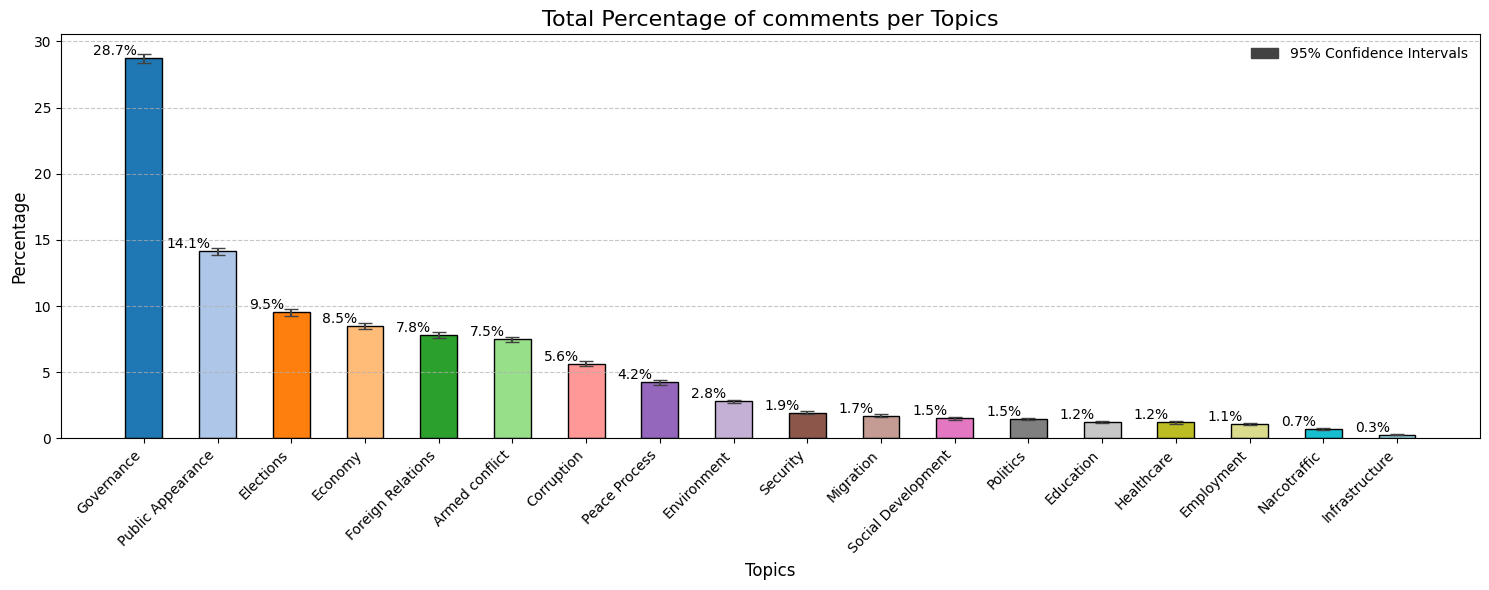

In [22]:
create_topic_visualizations_2(df_sentiment_grouped[['topic', 'score', 'video_id', 'date']])

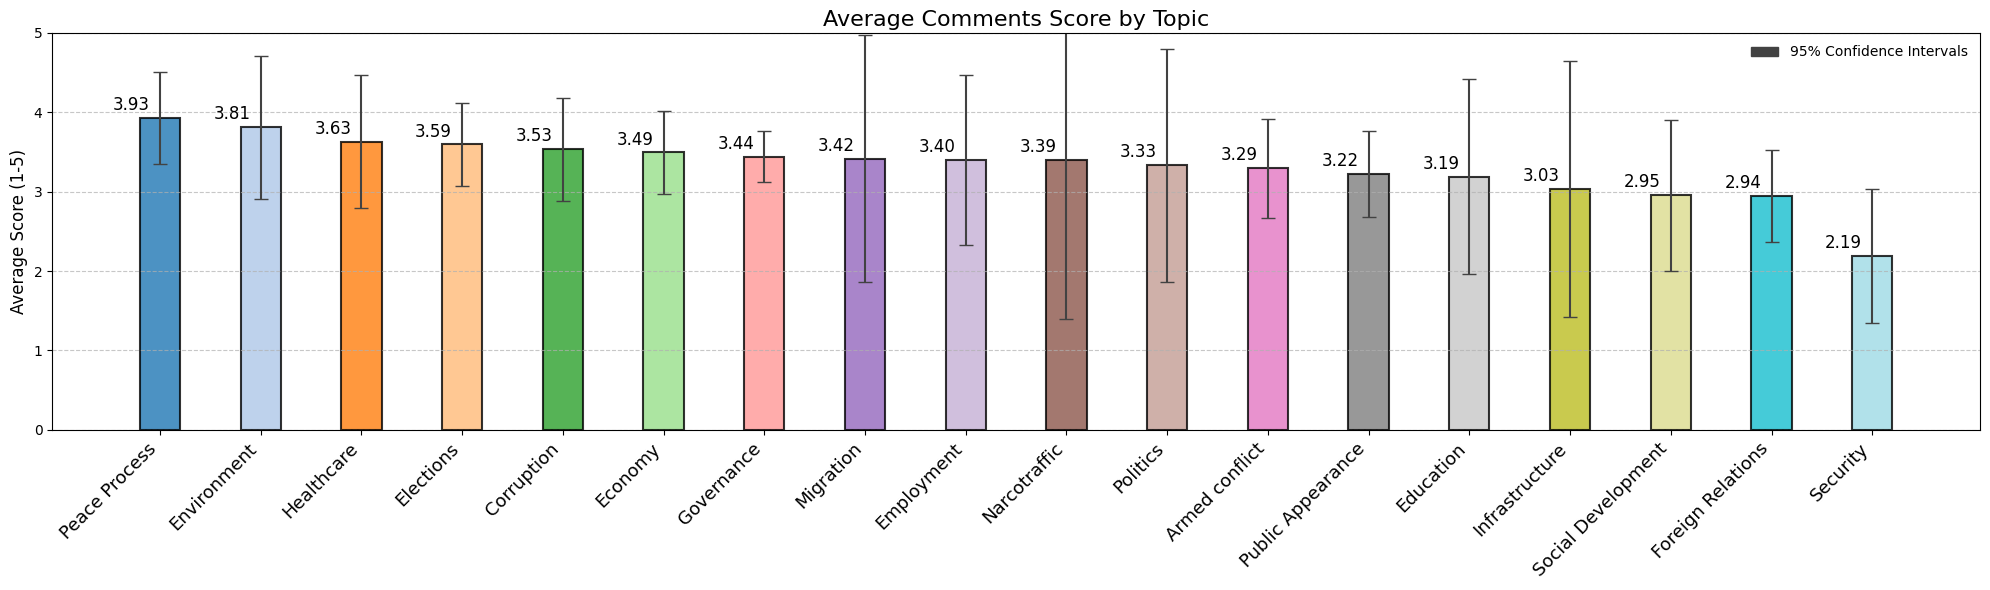

In [24]:
create_topic_vs_score_visualizations(df_sentiment_grouped[['topic', 'score', 'video_id']])

In [44]:
df_sentiment_videos = df_sentiment.merge(
        df_video_results[['video_id','score']].rename(columns={'score': 'video_score'}),
        on='video_id',
        how='left'
    )

### Contingency table

In [54]:
def create_contingency_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Creates a contingency table between video_score and score.

    Parameters:
    - df: DataFrame with columns 'video_score' and 'score'

    Returns:
    - contingency_table: pd.DataFrame
    """
    # Drop rows with missing values
    df_clean = df.dropna(subset=['video_score', 'score'])

    # Create contingency table
    contingency_table = pd.crosstab(df_clean['video_score'], df_clean['score'])

    return contingency_table

In [55]:
create_contingency_table(df_sentiment_videos[['video_score', 'score']])

score,1,2,3,4,5
video_score,,,,,
1,2899,725,238,994,1596
2,475,96,14,91,122
3,317,146,70,192,359
4,986,326,129,732,2337
5,2241,845,349,1586,7152


#### Comments vs Polls

In [25]:
polls_data = {
    'date': ['2024-01','2024-02','2024-03','2024-04','2024-05','2024-06','2024-07','2024-08','2024-09','2024-10','2024-11','2024-12','2025-01','2025-02','2025-03'],
    'Approved_percent': [33.01,34.83,31.47,32.88,32.00,30.43,31.94,30.34,30.27,33.67,32.72,31.89,35.63,37.04,34.29],
}
df_polls = pd.DataFrame(polls_data)

In [26]:
df_approval = monthly_counts_df.copy()
df_approval["Approved_percent"] = df_approval["4_percent"] + df_approval["5_percent"]

In [27]:
def create_polls_vs_sentiment_visualizations(df_approval: pd.DataFrame, df_polls: pd.DataFrame, min_month:str, max_month:str) -> None:
    """
    Create visualizations for polls vs sentiment, with 95% CI for TikTok line only.
    
    Parameters:
    df_approval: DataFrame with columns 'date', 'Approved_percent', 'total'
    df_polls: DataFrame with columns 'date', 'Approved_percent'
    
    Returns:
    None (displays plots)
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # X-axis
    x_data = range(len(df_polls['date']))

    ax1.set_title('Approval Percentage by Month', fontsize=14)
    ax1.set_ylabel('Approval (%)')
    ax1.set_xticks(x_data)
    ax1.set_xticklabels(df_polls['date'], rotation=45, ha='right')
    ax1.set_ylim(
        min(df_approval['Approved_percent'].min(), df_polls['Approved_percent'].min()) - 5,
        max(df_approval['Approved_percent'].max(), df_polls['Approved_percent'].max()) + 5
    )
    ax1.grid(True, linestyle='--', alpha=0.7)

    df_tiktok = df_approval.loc[min_month:max_month]

    # ---- CI for TikTok approval ----
    p = df_tiktok['Approved_percent'] / 100
    n = df_tiktok['total']
    se = np.sqrt(p * (1 - p) / n) * 100  # scale to percentage
    ci = 1.96 * se

    # Plot TikTok line with CI
    ax1.plot(x_data, df_tiktok['Approved_percent'], marker='o', linewidth=2, color='#3366CC', linestyle='--', label='TikTok')
    print(len(df_tiktok['Approved_percent']))
    print(len(ci))
    ax1.fill_between(
        x_data,
        df_tiktok['Approved_percent'] - ci,
        df_tiktok['Approved_percent'] + ci,
        color='#3366CC',
        alpha=0.2,
        label='95% Confidence Interval (TikTok)'
    )

    # Plot Polls line (no CI)
    ax1.plot(x_data, df_polls['Approved_percent'], marker='o', linewidth=2, color='#FF9999', linestyle='--', label='Polls')

    ax1.legend(title='Source')
    plt.tight_layout()
    plt.show()

15
15


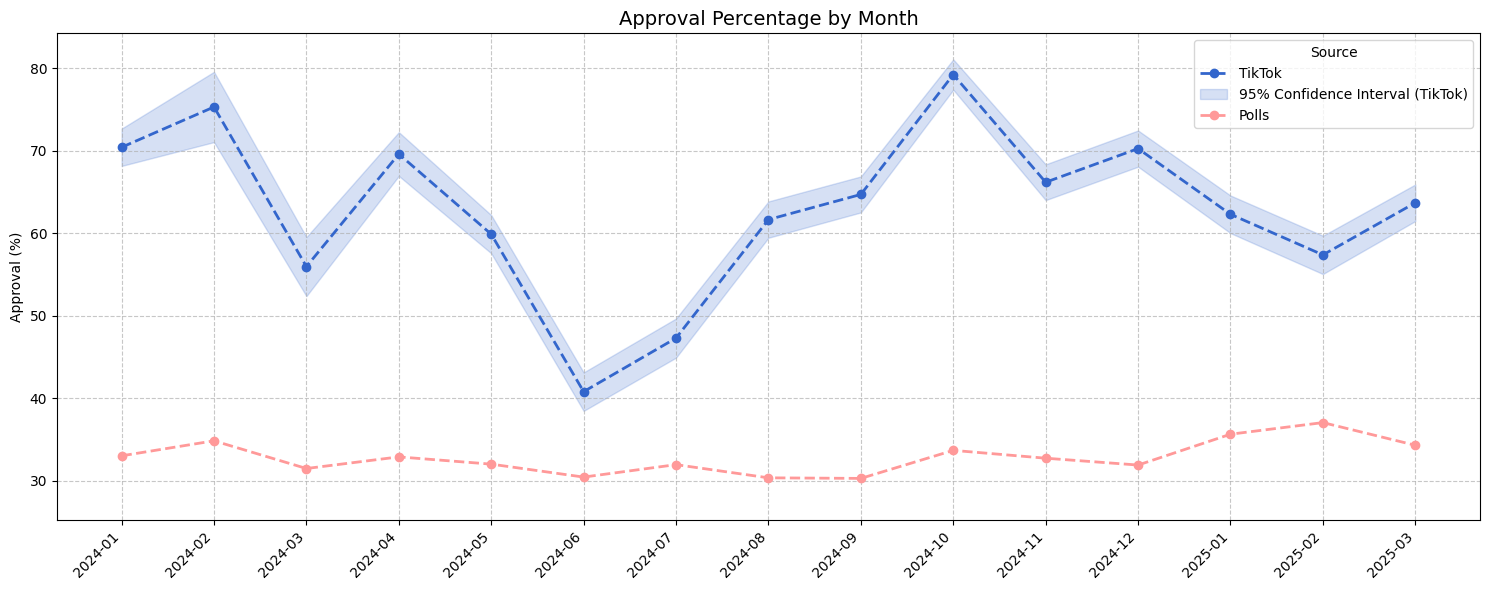

In [28]:
create_polls_vs_sentiment_visualizations(df_approval, df_polls,'2024-01','2025-03')